<a href="https://colab.research.google.com/github/danih02/Extracting-Guitar-Tabs-with-Multimodel-LLM/blob/main/Guitar_tabs_with_Gemini_2_0_flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In this note, we will try to read off tabular from videos. Some guitar player do not upload tabular of their cover but only a play along video with tabular at the bottom of the screen. Our aim is to use an llm (or any other kind of model) to extract the tabs in a convenient way.

In [ ]:
%%capture
%pip install langchain_google_genai

In [ ]:
with open('/content/drive/My Drive/google_api_key.txt', 'r') as f: # get api key
    api_key = f.read().strip()

import google.generativeai as genai
import os
genai.configure(api_key=api_key)

from langchain_google_genai import ChatGoogleGenerativeAI
os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17", temperature = 0)

In [ ]:
from langchain_core.output_parsers import StrOutputParser

In [ ]:
chain = llm | StrOutputParser()
print(chain.invoke("I How is it going?"))

I'm doing well, thank you for asking!

I'm here and ready to help. What can I do for you today?


# Tab with pictures

## Get frame of video

In [ ]:
import os
os.chdir('/content/drive/MyDrive/2025-05-13 Tab from video detection')

In [ ]:
import cv2

# Path to your MP4 file
video_path = 'Estas Tonne – Cuban Dance (Fingerstyle Guitar).mp4'  # 🔁 Replace with your actual path

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    raise IOError("Error opening video file")

# Get video metadata
fps = cap.get(cv2.CAP_PROP_FPS)  # frames per second
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(frame_count / fps)

# Dictionary to hold frames
frames = {}

print(f"Video FPS: {fps}, Total Frames: {frame_count}, Duration: {duration} seconds")

# Loop through each second
for second in range(duration):
    # Calculate the frame number for the given second
    frame_num = int(second * fps)

    # Set the video position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    # Read the frame
    ret, frame = cap.read()
    if not ret:
        print(f"Failed to read frame at {second} seconds")
        continue

    # Store in dictionary
    frames[second] = frame

# Release the video capture
cap.release()

print(f"✅ Extracted {len(frames)} frames (1 per second)")


Video FPS: 29.807, Total Frames: 4920, Duration: 165 seconds
✅ Extracted 165 frames (1 per second)


Let us make a quick test to see how good our llm can identify tabs. I took a screenshot of the video and we will ask the model to identify numbers.

## 0-shot test

Let us plot the image first.

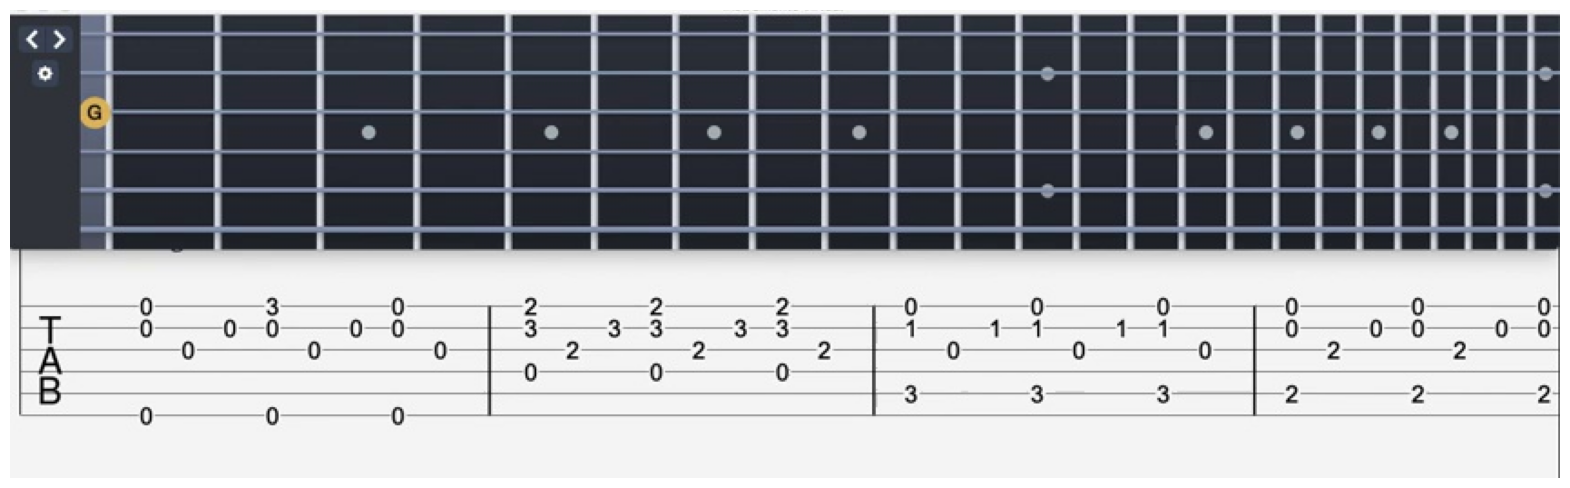

In [ ]:
tab_test_path = '/content/drive/MyDrive/2025-05-13 Tab from video detection/frames/frame_0000.jpg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 1, figsize=(20, 10))
img = mpimg.imread(tab_test_path)
axes.imshow(img)
axes.axis("off")
plt.show()

The idea is to get a output of the form

*   [0, -, -, 0, -, -, 0, -]
*   [0, -, 0, 0, -, 0, 0, -]
*   [-, 2, -, -, 2, -, -, 2]
*   [-, -, -, -, -, -, -, -]
*   [2, -, -, 2, -, -, 2, -]
*   [-, -, -, -, -, -, -, -]

for the highlighted chord in this picture. We already see a couple difficulties the llm has to pass

1.   Identify the number of chords
2.   Identify the numbers
1.   Different picture have different visible numbers per chord.

Let us vanilla check wether gemini 2.0 flash can handle this.

In [ ]:
import base64
from typing import List
from langchain_core.messages import HumanMessage
from langchain.schema import HumanMessage

# function to encode an image to base64
def encode_image_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# Encode the image
tab_encoded = encode_image_to_base64(tab_test_path)

# function to wrap llm input
def message(query: str) -> List[HumanMessage]:

    multimodal_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": query
        }
    ]

    return [HumanMessage(content=multimodal_content)]

In [ ]:
from langchain.schema.runnable import RunnableLambda

prompt = """
In this picture you see a tablature with numbers indicating the fret to be played on each string. There are 6 strings. Different chords are seperated by vectrical black lines.

Output the numbers, i.e, the notes, in the picture you see up to the first vertical black line (from left to right) in a structured format.

How many chords are in the picture?
"""
chain = (RunnableLambda(message)
          | llm
          | StrOutputParser())
print(chain.invoke(prompt))

Based on the picture, the notes up to the first vertical black line are:

```
[
  [0, 0, 0, 0, 0],  // String 1 (high E)
  [0, 0, 0, 0, 0],  // String 2 (B)
  [0, 0, 0, 0, 0],  // String 3 (G)
  [0, 3, 0, 3, 0],  // String 4 (D)
  [0, 0, 0, 0, 0],  // String 5 (A)
  [0, 0, 0, 0, 0]   // String 6 (low E)
]
```
*(Note: In this specific section, every string has a note played at each time point, so no "-" are present.)*

There are 5 chords (sections separated by vertical lines) visible in the picture.


I mean, the numbers are not too far off but this certainly does not work yet. Let us 1-shot prompt next and see if it works.

## 1-shot test

We take the same picture as before, but this time we instruct the model how to do it with an example picture.

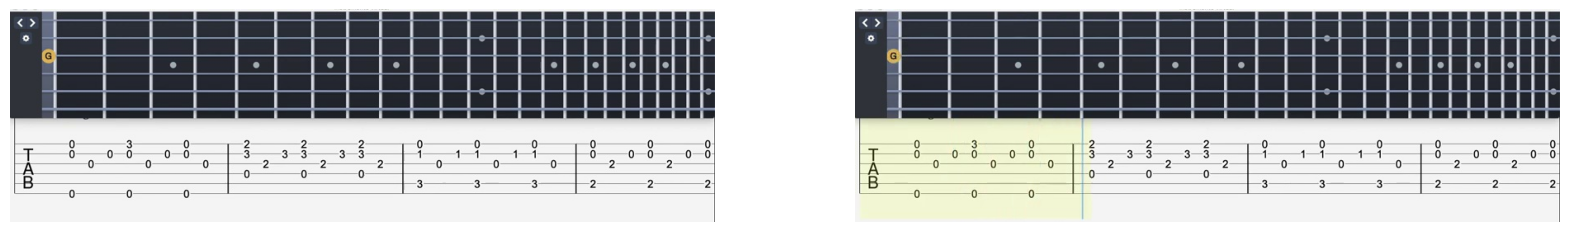

In [ ]:
tab_test_path_2 = '/content/drive/MyDrive/2025-05-13 Tab from video detection/frames/frame_0001.jpg'

images = [tab_test_path, tab_test_path_2]

import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax, image in zip(axes,images):
    img = mpimg.imread(image)
    ax.imshow(img)
    ax.axis("off")
plt.show()

In [ ]:
# Encode the image
tab_encoded_2 = encode_image_to_base64(tab_test_path_2)

# Prompt with 1-shot example
def message(query : str) -> List[HumanMessage]:
    content = [
        # Example image and explanation
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded_2}"
            }
        },
        {
            "type": "text",
            "text": """This is an example of a guitar tablature. From the picture, you can read of the following notes:

                      Chord 1:

                      {[0, -, -, 3, -, -, 0, -],
                      [0, -, 0, 0, -, 0, 0, -],
                      [-, 0, -, -, 0, -, -, 0],
                      [-, -, -, -, -, -, -, -],
                      [-, -, -, -, -, -, -, -],
                      [0, -, -, 0, -, -, 0, -]},

                      VERTICAL LINE

                      Chord 2:

                      {[2, -, -, 2, -, -, 2, -],
                      [3, -, 3, 3, -, 3, 3, -],
                      [-, 2, -, -, 2, -, -, 2],
                      [0, -, -, 0, -, -, 0, -],
                      [-, -, -, -, -, -, -, -],
                      [-, -, -, -, -, -, -, -]},

                      VERTICAL LINE

                      where a "-" means that the note is not played.
                      """
        },

        # Input image and task
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": query
        }
    ]
    return [HumanMessage(content=content)]

chain = RunnableLambda(message) | llm | StrOutputParser()

prompt = """
Now do the same for this image as in the example above. Before you start outputing the numbers, keep in mind that not every picture has the same amout of chords and vertical lines.
"""

result = chain.invoke(prompt)

print(result)

Here is the transcription of the guitar tablature from the image, following the format of the example:

Chord 1:

{[0, 0, 0, 0, 0, 0, 0, 0],
[3, 3, 3, 3, 3, 3, 3, 3],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0]},

VERTICAL LINE

Chord 2:

{[2, 2, 2, 2, 2, 2, 2, 2],
[3, 3, 3, 3, 3, 3, 3, 3],
[2, 2, 2, 2, 2, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 0, 0],
[-, -, -, -, -, -, -, -],
[-, -, -, -, -, -, -, -]},

VERTICAL LINE

Chord 3:

{[0, 0, 0, 0, -, -, -, -],
[1, 1, 1, 1, -, -, -, -],
[0, 0, 0, 0, -, -, -, -],
[0, 0, 0, 0, -, -, -, -],
[3, 3, 3, 3, -, -, -, -],
[-, -, -, -, -, -, -, -]},

VERTICAL LINE

Chord 4:

{[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 2, 2, 2, 2, 2, 2],
[2, 2, 2, 2, 2, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 0, 0]},

VERTICAL LINE

Chord 5:

{[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 2, 2, 2, 2, 2, 2],
[2, 2, 2, 2, 2, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 

This already works much better. But notice that in chord 4, the llm added a 2 which cannot be seen in the picture. But the be honest, the structure of every chord identical. Lets try it withc two very different pictures

In [ ]:
# Prompt with 1-shot example
def message(query : str) -> List[HumanMessage]:
    content = [
        # Example image and explanation
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": """This is an example of a guitar tablature. From the picture, you can read of the following notes:

                      Chord 1:

                      {[0, -, -, 3, -, -, 0, -],
                      [0, -, 0, 0, -, 0, 0, -],
                      [-, 0, -, -, 0, -, -, 0],
                      [-, -, -, -, -, -, -, -],
                      [-, -, -, -, -, -, -, -],
                      [0, -, -, 0, -, -, 0, -]},

                      VERTICAL LINE

                      where a "-" means that the note is not played.
                      """
        },

        # Input image and task
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": query
        }
    ]
    return [HumanMessage(content=content)]

chain = RunnableLambda(message) | llm | StrOutputParser()

prompt = """
Here you have the same picture again. Give me the tabs of the second chord. Output only that, nothing else
"""

result = chain.invoke(prompt)

print(result)

{[2, -, 2, -, 2, -, 2],
[3, 3, 3, 3, 3, 3, 3],
[2, -, 2, -, 2, -, 2],
[0, 0, 0, 0, 0, 0, 0],
[2, 2, 2, 2, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# Prompt with 1-shot example
def message(query : str) -> List[HumanMessage]:
    content = [
        # Example image and explanation
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": """This is an example of a guitar tablature. From the picture, you can read of the notes.

            I asked an LLM to extract the 2nd Chord. The output was

                      {[2, -, 2, 2, -, 0, -],
                      [3, -, 3, 3, -, 0, -],
                      [0, -, 2, 2, -, -, -],
                      [-, -, 0, 0, -, -, -],
                      [-, -, -, -, -, -, -],
                      [-, -, -, -, -, -, -]},

                      VERTICAL LINE

                      where a "-" means that the note is not played. I this correct?
                      """
        }
    ]
    return [HumanMessage(content=content)]

chain = RunnableLambda(message) | llm | StrOutputParser()


result = chain.invoke("")

print(result)

The LLM's output is a good attempt at representing the second chord in the tablature, but it has some inaccuracies and could be formatted more clearly. Here's a breakdown and a corrected version:

**Understanding the Tablature**

*   **Strings:** The lines in the tablature represent the strings of the guitar. From top to bottom, they are typically E (highest), B, G, D, A, E (lowest).
*   **Numbers:** The numbers indicate the fret to press down on that string. "0" means the open string.
*   **Vertical Lines:** Vertical lines separate measures or chords.

**Analyzing the Second Chord**

Looking at the image, the second chord in the tablature has the following notes:

*   **E (highest string):** 0 (open)
*   **B string:** 3 (3rd fret)
*   **G string:** 2 (2nd fret)
*   **D string:** 0 (open)
*   **A string:** 0 (open)
*   **E (lowest string):** 0 (open)

**Corrected Representation**

Here's a more accurate and readable representation of the second chord:

```
E: 0
B: 3
G: 2
D: 0
A: 0
E: 0

## 0-shot with simplified pictures

Possibly, the picture is the problem. For example, the video above the chords could be distracting. We also take another screenshot, which is even more simple. This example is exactly the same as above but with a nicer (and different) picture.

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/tab_test_3.png'

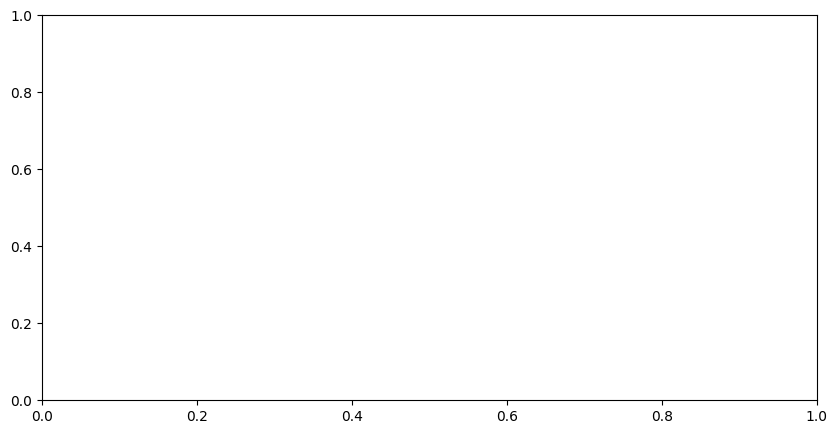

In [ ]:
tab_test_path_3 = '/content/drive/My Drive/tab_test_3.png'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
img = mpimg.imread(tab_test_path_3)
axes.imshow(img)
axes.axis("off")
plt.show()

In [ ]:
1# Encode the image
tab_encoded_3 = encode_image_to_base64(tab_test_path_3)

# function to wrap llm input
def message(query: str) -> List[HumanMessage]:

    multimodal_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded_3}"
            }
        },
        {
            "type": "text",
            "text": query
        }
    ]

    return [HumanMessage(content=multimodal_content)]

In [ ]:
from langchain.schema.runnable import RunnableLambda

prompt = """
In this picture you see a tablature with numbers indicating the fret to be played on each string. There are 6 strings. Different chords are seperated by vectrical black lines.

Output the numbers, i.e, the notes, in the picture you see up to the first vertical black line (from left to right) in a structured format.

How many chords are in the picture?
"""
chain = (RunnableLambda(message)
          | llm
          | StrOutputParser())
print(chain.invoke(prompt))

Here are the notes up to the first vertical black line:

*   **E string:** 0, 0, 0
*   **B string:** 0, 0, 3, 0, 0
*   **G string:** 0, 0, 0, 0, 0
*   **D string:** (no notes)
*   **A string:** 0, 0, 0, 0, 0
*   **E string:** 0, 0, 0

There are 4 chords in the picture.


The output is indeed closer to the 1st example, but still wrong.

# YOLO11

## download setup

In [ ]:
%%capture
%pip install ultralytics

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 model
model = YOLO("yolov8n.pt")  # or yolov8s.pt, yolov8m.pt, etc.

# Perform inference on an image or URL
source = 'https://ultralytics.com/images/zidane.jpg'
results = model.predict(source=source, save=True)

100%|██████████| 6.25M/6.25M [00:00<00:00, 111MB/s]


100%|██████████| 49.2k/49.2k [00:00<00:00, 32.1MB/s]


image 1/1 /content/drive/MyDrive/2025-05-13 Tab from video detection/zidane.jpg: 384x640 2 persons, 1 tie, 47.6ms
Speed: 12.5ms preprocess, 47.6ms inference, 363.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 0.,  0., 27.])
conf: tensor([0.8360, 0.8190, 0.2910])
data: tensor([[1.1487e+02, 1.9741e+02, 1.1145e+03, 7.1189e+02, 8.3597e-01, 0.0000e+00],
        [7.4846e+02, 4.1855e+01, 1.1431e+03, 7.1302e+02, 8.1896e-01, 0.0000e+00],
        [4.3947e+02, 4.3707e+02, 5.2435e+02, 7.0916e+02, 2.9097e-01, 2.7000e+01]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([3, 6])
xywh: tensor([[614.6694, 454.6507, 999.5989, 514.4774],
        [945.7686, 377.4396, 394.6143, 671.1687],
        [481.9103, 573.1166,  84.8712, 272.0862]])
xywhn: tensor([[0.4802, 0.6315, 0.7809, 0.7146],
        [0.7389, 0.5242, 0.3083, 0.9322],
        [0.3765, 0.7960, 0.0663, 0.3779]])
xyxy: tensor([[ 114.8700,  197.4120, 1114.4689,  711.8894],
        [ 748.4614,   41.8552, 1143.0757,  713.0239],
        [ 439.4747,  437.0735,  524.3459,  709.1597]])
xyxyn: tensor([[0.0897, 0.2742, 0.8707, 0.9887],
        [0.5847, 0.0581, 0.8930, 0.99

## train on public dataset

In [ ]:
import os
path = '/content/drive/MyDrive/2025-05-13 Tab from video detection'
os.chdir(path)

In [ ]:
import yaml

# Load the YAML file
with open('data.yaml', 'r') as f:
    data = yaml.safe_load(f)

# Print the contents
print(data)

# Access specific parts (optional)
print("Classes:", data['names'])
print("Training path:", data['train'])


{'names': ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'], 'nc': 13, 'roboflow': {'license': 'CC BY 4.0', 'project': 'numbers-gw8hr', 'url': 'https://universe.roboflow.com/ahmet-lxjbf/numbers-gw8hr/dataset/1', 'version': 1, 'workspace': 'ahmet-lxjbf'}, 'test': '../test/images', 'train': '/content/drive/MyDrive/2025-05-13 Tab from video detection/train/images', 'val': '/content/drive/MyDrive/2025-05-13 Tab from video detection/valid/images'}
Classes: ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
Training path: /content/drive/MyDrive/2025-05-13 Tab from video detection/train/images


In [ ]:

with open('data.yaml', 'r') as f:
    data = yaml.safe_load(f)

# Modify the paths (update these to your actual paths)
data['train'] = path + '/train/images'
data['val'] = path + '/valid/images'

# (Optional) print to confirm
print(data)

# Write the modified data back to the YAML file
with open('data.yaml', 'w') as f:
    yaml.safe_dump(data, f)


{'names': ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'], 'nc': 13, 'roboflow': {'license': 'CC BY 4.0', 'project': 'numbers-gw8hr', 'url': 'https://universe.roboflow.com/ahmet-lxjbf/numbers-gw8hr/dataset/1', 'version': 1, 'workspace': 'ahmet-lxjbf'}, 'test': '../test/images', 'train': '/content/drive/MyDrive/2025-05-13 Tab from video detection/train/images', 'val': '/content/drive/MyDrive/2025-05-13 Tab from video detection/valid/images'}


In [ ]:
# Train
model.train(
    data='./data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8x-digits',
    project='digit-detection'
)


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8x-digits5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]

Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,013,383 parameters, 3,013,367 gradients, 8.2 GFLOPs

Transferred 58/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.1 ms, read: 0.1±0.0 MB/s, size: 23.2 KB)


train: Scanning /content/drive/MyDrive/2025-05-13 Tab from video detection/train/labels.cache... 1467 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1467/1467 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 45.5 KB)


val: Scanning /content/drive/MyDrive/2025-05-13 Tab from video detection/valid/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00:00<?, ?it/s]


Plotting labels to digit-detection/yolov8x-digits5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to digit-detection/yolov8x-digits5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.47G      2.149      3.805      1.779        188        640: 100%|██████████| 92/92 [00:32<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:22<00:00, 11.26s/it]

                   all         64        659   0.000931     0.0122   0.000503   0.000172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.49G      1.602      2.388      1.297        134        640: 100%|██████████| 92/92 [00:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         64        659     0.0552     0.0625     0.0241     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.93G      1.432      1.823      1.212        166        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         64        659     0.0569     0.0769     0.0465     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.93G      1.327      1.502      1.144        207        640: 100%|██████████| 92/92 [00:28<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         64        659      0.099     0.0892     0.0569     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.94G      1.266      1.343      1.114        106        640: 100%|██████████| 92/92 [00:29<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         64        659      0.122      0.134      0.072     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.94G      1.186      1.185      1.076        208        640: 100%|██████████| 92/92 [00:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         64        659      0.121      0.174     0.0791     0.0433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.94G      1.174      1.132      1.063        169        640: 100%|██████████| 92/92 [00:30<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         64        659      0.146      0.161      0.099     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.94G      1.127      1.061      1.048        172        640: 100%|██████████| 92/92 [00:28<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         64        659      0.163      0.172      0.097     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.94G      1.127      1.012      1.044        125        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         64        659      0.152      0.166      0.109     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.94G       1.11     0.9949      1.037        135        640: 100%|██████████| 92/92 [00:30<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         64        659      0.166       0.19      0.114      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.94G      1.086     0.9533      1.024        154        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         64        659      0.149      0.221      0.119     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.57G      1.041     0.9181      1.005        105        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         64        659      0.159       0.21      0.121     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.57G      1.055     0.9012      1.008        155        640: 100%|██████████| 92/92 [00:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         64        659      0.209      0.209      0.142     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.57G      1.035     0.8759       1.01        139        640: 100%|██████████| 92/92 [00:29<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         64        659      0.209      0.178      0.134     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.57G      1.011     0.8502     0.9956         79        640: 100%|██████████| 92/92 [00:28<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         64        659      0.212      0.185      0.132     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.57G       1.02     0.8501     0.9986         92        640: 100%|██████████| 92/92 [00:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         64        659      0.202      0.218       0.15      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.57G     0.9757       0.81     0.9846        133        640: 100%|██████████| 92/92 [00:28<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


                   all         64        659      0.209      0.212       0.14     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.59G     0.9848      0.814     0.9821        171        640: 100%|██████████| 92/92 [00:27<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         64        659      0.219       0.23      0.144     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.59G     0.9931     0.8134     0.9861        111        640: 100%|██████████| 92/92 [00:28<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         64        659       0.23      0.232      0.153     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.59G     0.9818     0.7858     0.9811        128        640: 100%|██████████| 92/92 [00:29<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         64        659      0.211      0.233      0.156     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.59G     0.9542     0.7542     0.9725        102        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         64        659      0.199      0.187       0.14     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.59G     0.9462     0.7612     0.9686        205        640: 100%|██████████| 92/92 [00:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         64        659      0.288      0.222      0.162     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.59G     0.9465     0.7548     0.9685        267        640: 100%|██████████| 92/92 [00:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         64        659      0.294      0.219      0.167        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.59G     0.9259     0.7341     0.9658        134        640: 100%|██████████| 92/92 [00:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         64        659      0.235      0.282      0.176      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.61G     0.9284     0.7088      0.964        136        640: 100%|██████████| 92/92 [00:28<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         64        659      0.243       0.26      0.183      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.61G     0.9189      0.709     0.9557        171        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         64        659      0.285      0.251      0.183      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.61G     0.9185     0.7133     0.9561        105        640: 100%|██████████| 92/92 [00:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         64        659       0.28      0.285      0.199      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.61G     0.9055     0.6946     0.9574        160        640: 100%|██████████| 92/92 [00:30<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         64        659      0.295      0.282      0.193      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.61G     0.9079     0.7001     0.9555        141        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         64        659      0.307      0.262      0.202      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.61G     0.8773     0.6708     0.9491        122        640: 100%|██████████| 92/92 [00:29<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         64        659      0.277      0.302      0.204      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.61G     0.9035     0.6849     0.9573        167        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         64        659      0.264      0.312      0.198      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.61G     0.8759     0.6804     0.9442        187        640: 100%|██████████| 92/92 [00:28<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         64        659      0.293      0.313      0.213      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.61G     0.8685     0.6525      0.945        155        640: 100%|██████████| 92/92 [00:29<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         64        659      0.274      0.297      0.215      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.61G     0.8741     0.6684     0.9355        122        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         64        659      0.291      0.271      0.204      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.61G     0.8633     0.6447     0.9366        158        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         64        659       0.28       0.28      0.203      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.61G     0.8614     0.6608      0.939        120        640: 100%|██████████| 92/92 [00:30<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         64        659      0.267      0.303      0.217      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.61G     0.8694     0.6502     0.9448        100        640: 100%|██████████| 92/92 [00:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         64        659       0.27      0.307      0.207      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.61G     0.8438     0.6407     0.9297        143        640: 100%|██████████| 92/92 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         64        659      0.308      0.294      0.213       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.61G      0.846     0.6272     0.9317        133        640: 100%|██████████| 92/92 [00:28<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         64        659      0.285      0.291      0.216      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.61G     0.8596      0.636     0.9371        171        640: 100%|██████████| 92/92 [00:28<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         64        659      0.279      0.326      0.223      0.139


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.62G     0.7973     0.5448     0.9208         75        640: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         64        659      0.293       0.28      0.215      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.62G     0.7807     0.5414     0.9135         83        640: 100%|██████████| 92/92 [00:27<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         64        659      0.299        0.3      0.218      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.62G     0.7764     0.5332     0.9117         68        640: 100%|██████████| 92/92 [00:27<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         64        659      0.286      0.312      0.225       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.62G     0.7748     0.5264     0.9091         67        640: 100%|██████████| 92/92 [00:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         64        659      0.305       0.31      0.223       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.62G     0.7666     0.5194     0.9115         85        640: 100%|██████████| 92/92 [00:27<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         64        659      0.302      0.317      0.227      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.62G      0.753     0.5103     0.9035         83        640: 100%|██████████| 92/92 [00:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         64        659      0.301      0.321      0.228      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.62G     0.7519     0.5122     0.9056         86        640: 100%|██████████| 92/92 [00:27<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         64        659      0.301      0.306      0.223      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.62G     0.7509     0.5142     0.9034         79        640: 100%|██████████| 92/92 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         64        659      0.296      0.311      0.222       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.62G     0.7455      0.503     0.9015        105        640: 100%|██████████| 92/92 [00:29<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         64        659      0.289      0.308      0.221      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.62G     0.7408     0.4987     0.9022        102        640: 100%|██████████| 92/92 [00:27<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         64        659        0.3      0.306       0.22      0.139



50 epochs completed in 0.429 hours.
Optimizer stripped from digit-detection/yolov8x-digits5/weights/last.pt, 6.3MB
Optimizer stripped from digit-detection/yolov8x-digits5/weights/best.pt, 6.3MB

Validating digit-detection/yolov8x-digits5/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


                   all         64        659      0.301      0.321      0.228      0.142
                     0         46        125      0.343      0.304      0.244      0.159
                     1         46        114      0.347      0.333      0.242       0.12
                     2         45        137      0.388      0.533      0.325      0.201
                     3         38         70      0.211      0.171      0.151     0.0952
                     4         28         41      0.272      0.244      0.152     0.0829
                     5         33         54      0.177      0.111     0.0834     0.0582
                     6         16         33      0.273      0.273      0.185      0.113
                     7         16         31      0.521      0.631      0.462      0.286
                     8         12         21      0.241      0.333      0.212      0.136
                     9         18         33      0.242      0.273      0.222      0.167
Speed: 0.3ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7501415dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.0460

In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO(path + '/digit-detection/yolov8x-digits5/weights/best.pt')

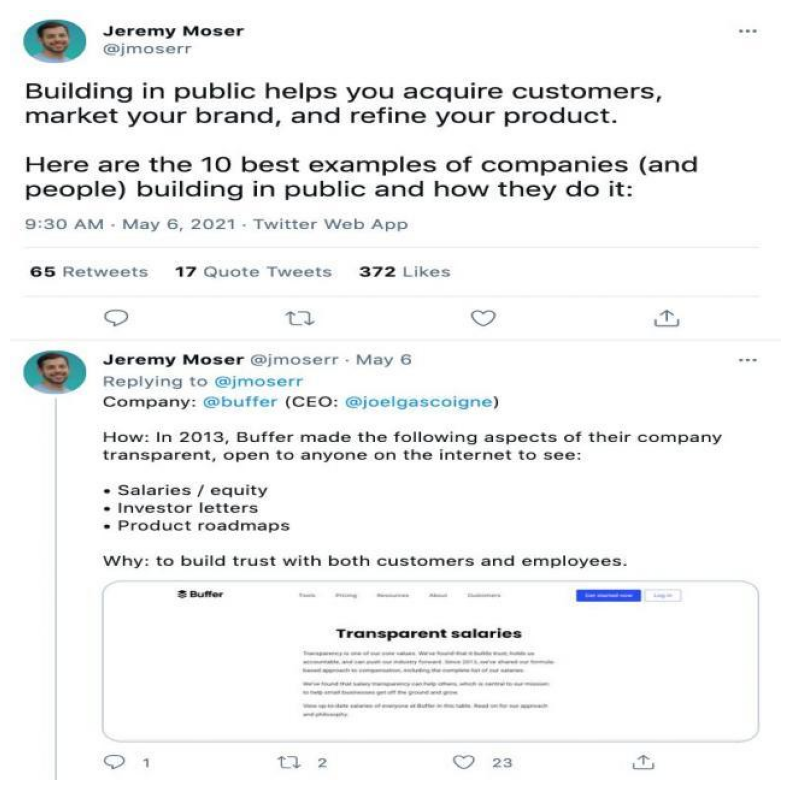

In [ ]:
tab_test_path = '/content/drive/MyDrive/2025-05-13 Tab from video detection/valid/images/15_png_jpg.rf.acce911ecc599c0e60e4a2f3f4ed7910.jpg'

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(20, 10))
img = mpimg.imread(tab_test_path)
axes.imshow(img)
axes.axis("off")
plt.show()


image 1/1 /content/drive/MyDrive/2025-05-13 Tab from video detection/valid/images/15_png_jpg.rf.acce911ecc599c0e60e4a2f3f4ed7910.jpg: 640x640 1 2, 34.6ms
Speed: 5.8ms preprocess, 34.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


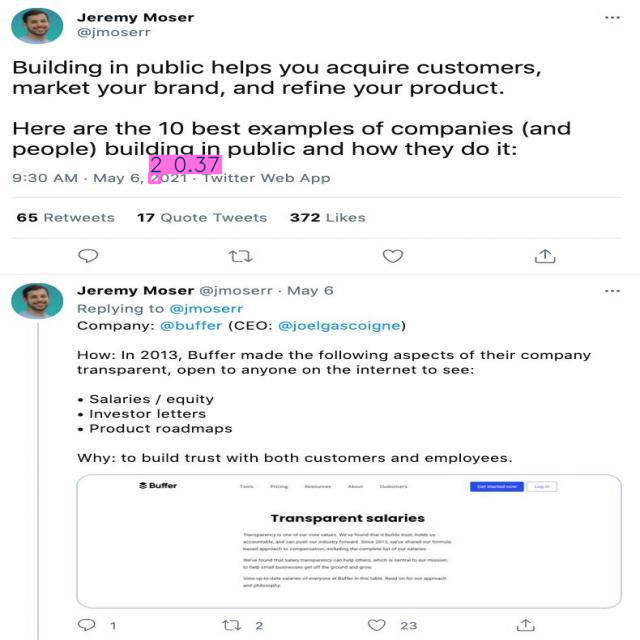

In [ ]:
results = model.predict(tab_test_path)

# Show results
results[0].show()  # Display image with bounding boxes

# Pydantic way

In [ ]:
%%capture
%pip install langchain-community langchain_google_genai

In [ ]:
import json
import argparse
from pydantic import BaseModel, validator, ValidationError
from typing import List, Union

# LangChain & Gemini imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage, SystemMessage

# 1. Define Pydantic model for guitar tab
class GuitarTab(BaseModel):
    e: List[Union[int, str]]
    B: List[Union[int, str]]
    G: List[Union[int, str]]
    D: List[Union[int, str]]
    A: List[Union[int, str]]
    E: List[Union[int, str]]

    @validator('*', pre=True)
    def validate_notes(cls, v):
        # Ensure each element is int or valid symbol
        cleaned = []
        for i in v:
            if isinstance(i, str) and i.isdigit():
                cleaned.append(int(i))
            elif isinstance(i, int) or i in ['x', '-']:
                cleaned.append(i)
            else:
                raise ValueError(f"Invalid tab symbol: {i}")
        return cleaned

    @validator('*')
    def check_length_consistency(cls, v, values, field):
        # Ensure all strings have equal length
        other_strings = {k: lst for k, lst in values.items() if isinstance(lst, list)}
        if other_strings:
            expected_len = len(next(iter(other_strings.values())))
            if len(v) != expected_len:
                raise ValueError(f"Length of {field.name} ({len(v)}) does not match expected ({expected_len})")
        return v

# 2. Configure Gemini model via LangChain
gemini_model = ChatGoogleGemini(model="gemini-pro", temperature=0.0)

# 3. LLM call & validation loop
def generate_valid_tab(prompt: str, image_path: str = None, max_retries: int = 3) -> GuitarTab:
    """
    Sends a prompt to Google Gemini via LangChain, optionally with an image, expecting JSON matching GuitarTab schema.
    Retries until valid or exceeds max_retries.
    """
    # Load image bytes if provided
    image_bytes = None
    if image_path:
        with open(image_path, 'rb') as f:
            image_bytes = f.read()

    system_msg = (
        "You are a helpful assistant that outputs guitar tabs as JSON matching the GuitarTab schema. "
        "Use -1 for strings not played. Do not include any extra keys."
    )

    for attempt in range(1, max_retries + 1):
        # Construct messages and optional image attachment
        messages = [SystemMessage(content=system_msg), HumanMessage(content=prompt)]
        # Gemini supports multimodal: pass image via additional_kwargs
        if image_bytes:
            response = gemini_model(messages, additional_kwargs={"image": image_bytes})
        else:
            response = gemini_model(messages)

        raw = response.content.strip()
        try:
            data = json.loads(raw)
            tab = GuitarTab(**data)
            print(f"✅ Success on attempt {attempt}")
            return tab
        except (json.JSONDecodeError, ValidationError) as e:
            print(f"❌ Attempt {attempt} failed: {e}")
            prompt = (
                f"The JSON you returned is invalid. Error: {e}. "
                f"Please output only valid JSON matching the schema: {GuitarTab.schema()}"
            )

    raise RuntimeError(f"Failed to get valid tab after {max_retries} attempts")

# 4. CLI interface
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Extract guitar tab from an image using Gemini + Pydantic validation.")
    parser.add_argument("--image", type=str, help="Path to the tab image file")
    parser.add_argument("--prompt", type=str, default=(
        "Extract the guitar tab from the provided image and return as JSON. "
        "Ensure all six strings (e, B, G, D, A, E) are present. Use -1 for strings not played."
    ), help="Custom prompt for Gemini")
    args = parser.parse_args()

    try:
        tab = generate_valid_tab(args.prompt, image_path=args.image)
        print(tab.json(indent=2))
    except Exception as e:
        print(f"Error: {e}")


<ipython-input-58-ee154fd8d538>:19: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('*', pre=True)
<ipython-input-58-ee154fd8d538>:32: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('*')


PydanticUserError: The `field` and `config` parameters are not available in Pydantic V2, please use the `info` parameter instead.

For further information visit https://errors.pydantic.dev/2.11/u/validator-field-config-info